In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['artgor-utils', 'generate-a-bit-more-feature-and-save-part2', 'LANL-Earthquake-Prediction', 'generate-a-bit-more-feature-and-save-part1']


In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from itertools import product

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

from IPython.display import HTML
import json
import altair as alt

###################################################


from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor


In [3]:
import os
import time
import datetime
import json
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v3
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error}}
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [4]:
test_data_p1 = pd.read_csv('../input/generate-a-bit-more-feature-and-save-part1/test_data_part1.csv')
training_data_p1 = pd.read_csv('../input/generate-a-bit-more-feature-and-save-part1/training_data_part1.csv')
test_data_p2 = pd.read_csv('../input/generate-a-bit-more-feature-and-save-part2/test_data_part2.csv')
training_data_p2 = pd.read_csv('../input/generate-a-bit-more-feature-and-save-part2/training_data_part2.csv')

In [5]:
X1 = training_data_p1.drop(['target', 'seg_id','Unnamed: 0'], axis=1)
X2 = training_data_p2.drop(['target', 'seg_id','Unnamed: 0'], axis=1)
X_test1 = test_data_p1.drop(['target', 'seg_id','Unnamed: 0'], axis=1)
X_test2 = test_data_p2.drop(['target', 'seg_id','Unnamed: 0'], axis=1)
test_segs = test_data_p1.seg_id
y = training_data_p1.target

X = pd.concat([X1, X2], axis=1)
X_test = pd.concat([X_test1, X_test2], axis=1)

X = X[:-1]
y = y[:-1]

In [6]:
# Fixing missing values
means_dict = {}
drop_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value
        if X[col].isnull().any():
            drop_dict[col] = 1
            X = X.drop(col,axis = 1)
for col in X_test.columns:
    if X_test[col].isnull().any():
        if col in means_dict:
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
        if col in drop_dict:
            X_test = X_test.drop(col,axis = 1)

power_imag_autocorr_w3000_lag50
power_imag_autocorr_w5000_lag30
power_imag_autocorr_w5000_lag40
power_imag_autocorr_w5000_lag50
power_imagratio_autocorr_w3000_lag50
power_imagratio_autocorr_w5000_lag30
power_imagratio_autocorr_w5000_lag40
power_imagratio_autocorr_w5000_lag50
power_power_autocorr_w3000_lag50
power_power_autocorr_w5000_lag30
power_power_autocorr_w5000_lag40
power_power_autocorr_w5000_lag50
power_powerratio_autocorr_w3000_lag50
power_powerratio_autocorr_w5000_lag30
power_powerratio_autocorr_w5000_lag40
power_powerratio_autocorr_w5000_lag50
power_real_autocorr_w3000_lag50
power_real_autocorr_w5000_lag30
power_real_autocorr_w5000_lag40
power_real_autocorr_w5000_lag50
power_realratio_autocorr_w3000_lag50
power_realratio_autocorr_w5000_lag30
power_realratio_autocorr_w5000_lag40
power_realratio_autocorr_w5000_lag50


Basic Model was submitted in the previous kernel https://www.kaggle.com/wangjilin/lanl-lgb-xgb-even-more-features-fitting and got score 1.441

# NN features

Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [8]:
np.shape(X)

(4194, 2938)

In [9]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist

CPU times: user 4min 34s, sys: 260 ms, total: 4min 35s
Wall time: 1min 10s


In [10]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Mon May 20 02:47:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[443]	training's l1: 1.44041	valid_1's l1: 2.15656
Fold 2 started at Mon May 20 02:47:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[707]	training's l1: 1.20032	valid_1's l1: 2.00487
Fold 3 started at Mon May 20 02:48:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[858]	training's l1: 1.08305	valid_1's l1: 1.9821
Fold 4 started at Mon May 20 02:48:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[502]	training's l1: 1.38366	valid_1's l1: 1.95601
Fold 5 started at Mon May 20 02:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[378]	training's l1: 1.49965	valid_1's l1: 2.20698
Fold 6 started at Mon May 20 02:49:25 201

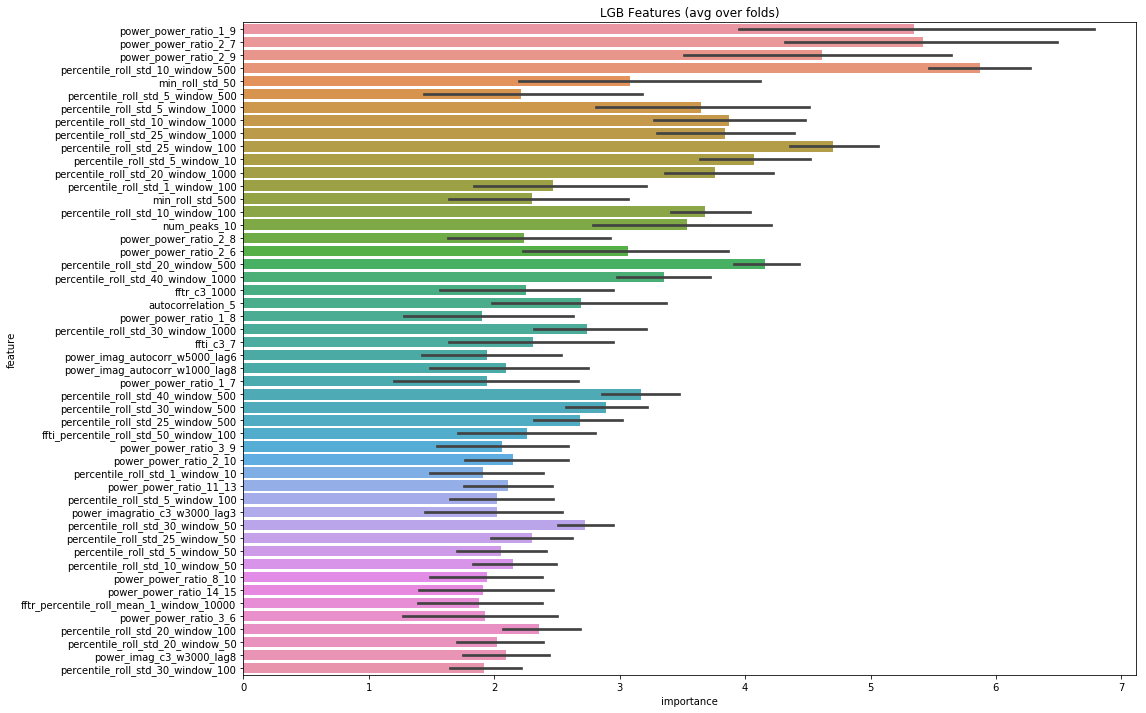

In [11]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
result_dict_lgb = train_model_regression(X=X_train_scaled, X_test=X_test_scaled, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [12]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_feature_scaled_NN_lgb.csv')

**Dropping highly correlated features**

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 1 started at Mon May 20 02:52:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's l1: 1.53729	valid_1's l1: 2.15585
Fold 2 started at Mon May 20 02:52:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[613]	training's l1: 1.2919	valid_1's l1: 2.02081
Fold 3 started at Mon May 20 02:52:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[767]	training's l1: 1.16672	valid_1's l1: 1.98882
Fold 4 started at Mon May 20 02:53:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[715]	training's l1: 1.20939	valid_1's l1: 1.97304
Fold 5 started at Mon May 20 02:53:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's l1: 1.49061	valid_1's l1: 2.22815
Fold 6 started at Mon May 20 02:53:44 201

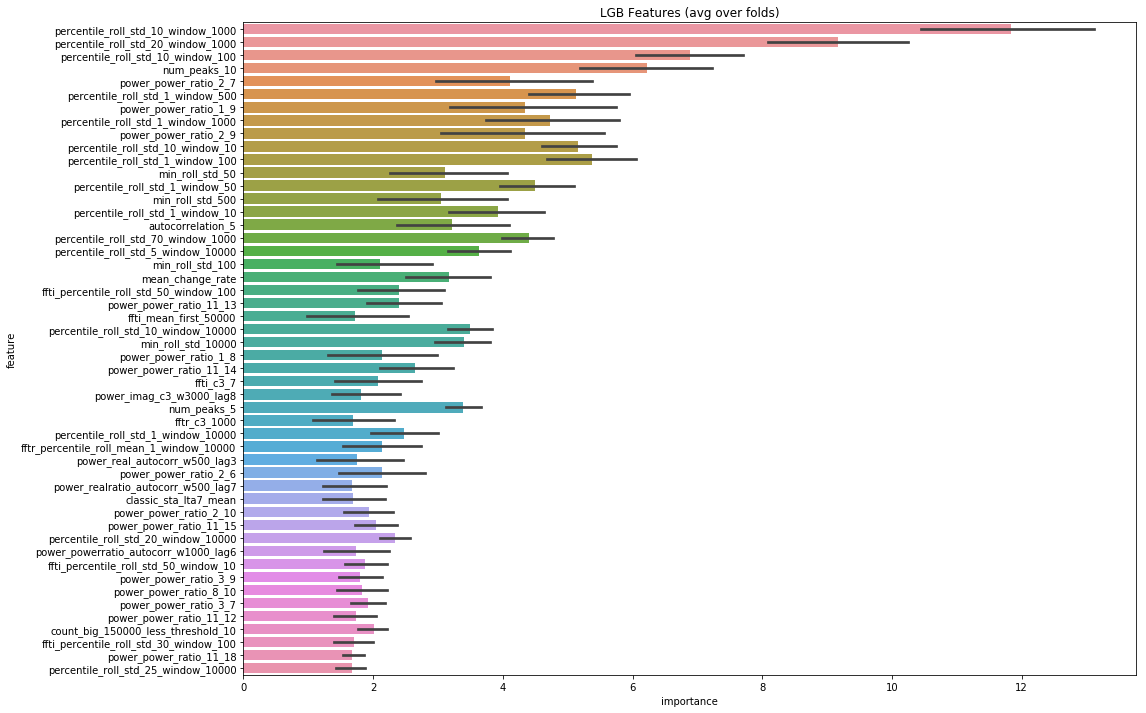

In [13]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_no_corr = X.drop(to_drop, axis=1)
X_test_no_corr = X_test.drop(to_drop, axis=1)
result_dict_lgb_no_corr = train_model_regression(X_no_corr, X_test_no_corr, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

submission['time_to_failure'] = result_dict_lgb_no_corr['prediction']
submission.to_csv('submission_no_corr.csv')

Fold 1 started at Mon May 20 02:56:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	training's l1: 1.51297	valid_1's l1: 2.16273
Fold 2 started at Mon May 20 02:56:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[680]	training's l1: 1.23518	valid_1's l1: 2.01317
Fold 3 started at Mon May 20 02:56:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[571]	training's l1: 1.33352	valid_1's l1: 1.99982
Fold 4 started at Mon May 20 02:56:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[440]	training's l1: 1.46703	valid_1's l1: 1.98288
Fold 5 started at Mon May 20 02:57:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's l1: 1.49077	valid_1's l1: 2.22495
Fold 6 started at Mon May 20 02:57:23 20

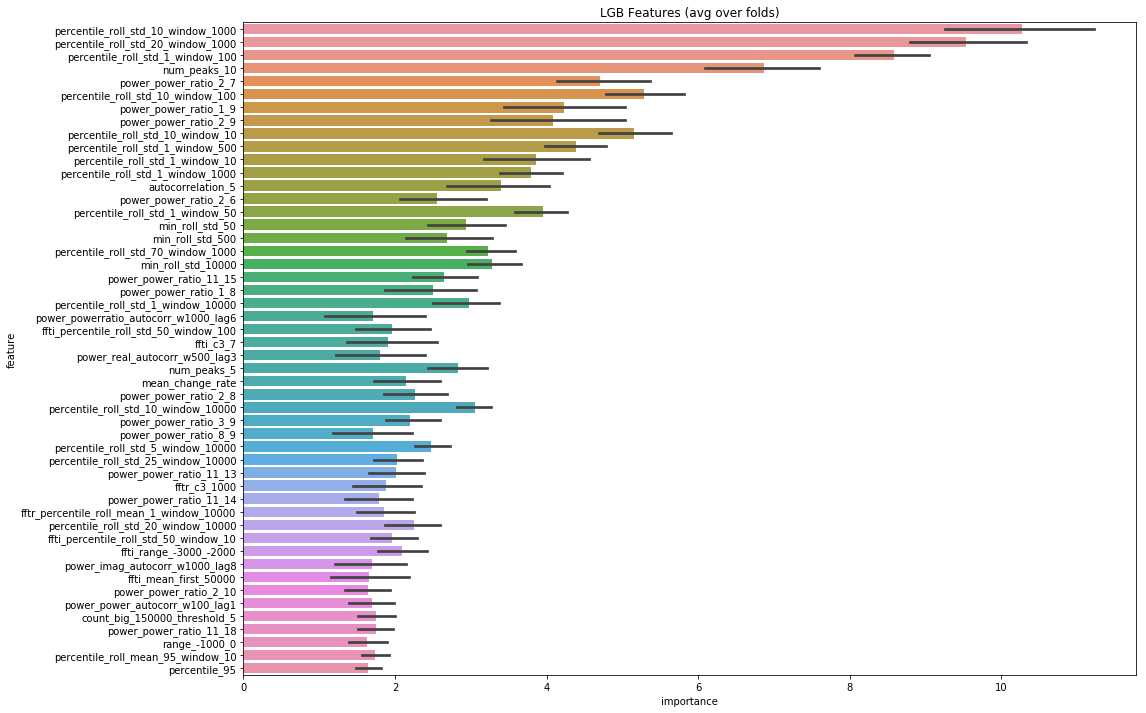

In [14]:
#X=X_train_scaled, X_test=X_test_scaled
corr_matrix = X_train_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_train_scaled_no_corr = X_train_scaled.drop(to_drop, axis=1)
X_test_scaled_no_corr = X_test_scaled.drop(to_drop, axis=1)
result_dict_lgb_lgb = train_model_regression(X_train_scaled_no_corr, X_test_scaled_no_corr, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_no_corr_feature_scaled_nn.csv')